# Задача 1.3
Задана выборка пар изображений: каждая пара состоит из оригинального (original_id.bmp) изображения и искаженного (modified_id_phrase.bmp). Также задана пара контрольных изображений original_test, modified_test.

В 99% случаев искажение заключается в добавлении шума. В 1% случаев искажение заключается в добавлении к изображению скрытого сообщения. Алгоритм заключается в следующем:

- У исходной фразы берутся порядковые номера всех символов в порядке английского алфавита (abcz -> 0,1,2,25).
- Полученный вектор домножается на неизвестный коэффициент alpha и складывается с вектором картинки (image = image.flatten() + $\alpha$*v).
- Если фраза слишком короткая, искажение продолжается периодически.

Требуется раскодировать фразу из контрольной пары.

NB: предполагается, что вы найдете искаженные изображения без шума с применением статистических моделей, а не перебором.

# Решение

In [1]:
import imageio as img
from statsmodels.regression.linear_model import OLS
import scipy.stats as st
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
%matplotlib inline

Считаем все картинки. Будем сразу получать разность векторов картинок modified - original. То что получили - либо шум, либо вектор.

In [2]:
mypath = "./images/images_full/images/"
image_filenames = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
original = dict()
modified = dict()
for name in image_filenames:
    splited = name.split(".")[0].split("_")
    if splited[0] == "modified":
        modified[int(splited[1])] = (mypath + name, splited[2])
    else:
        original[int(splited[1])] = mypath + name

In [4]:
samples = []
for i in original:
    delta = np.array(img.imread(modified[i][0]).flatten(), dtype=int) - np.array(img.imread(original[i]).flatten(), dtype=int)
    
    word = np.array(list(map(lambda c: ord(c) - ord("a"), 
                         (modified[i][1]*(len(delta)//len(modified[i][1])) + "a" * len(modified[i][1]))[:len(delta)])), 
                    dtype=int)
    # last two bits aren't in work
    samples.append((delta[:-2], word[:-2]))

In [5]:
test = (np.array(img.imread("./images/images_full/modified_test.bmp").flatten(), dtype=int) - np.array(img.imread("./images/images_full/original_test.bmp").flatten(), dtype=int))[:-2]

In [6]:
test[-30:]

array([13, 53, 13, 56, 60, 22, 13, 38, 44, 41, 13, 75, 35, 13,  3, 44, 69,
       56, 31, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [7]:
test = test[:-10]

In [8]:
LEN = len(samples[0][0])

In [9]:
for i in range(len(samples)):
    if LEN != len(samples[i][0]):
        print("WRONG")

Все картинки имеют одинаковый размер LEN

In [10]:
LEN, len(samples)

(4094, 1000)

Сразу можно видеть, что есть две приципиальные картины получившегося:

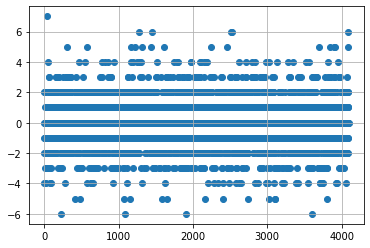

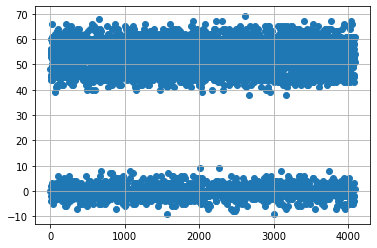

In [11]:
for i in [0, 16]:
    plt.scatter(range(len(samples[i][0])), samples[i][0])
    plt.grid()
    plt.show()

Отделим несодержательные картинки и найдем $\alpha$

Для этого будем делать линейную регрессию, получая коэффициент и тест Фишера (Стьюдента), что он не равен 0

In [12]:
def linreg(y, x):
    simple_model = OLS.from_formula("y~x-1", {"y": y, "x": x}).fit()
    res = simple_model.summary().tables[1].data[1]
    return float(res[1]), float(res[4])

In [13]:
p_vals = []
alphas = []
for i in range(len(samples)):
    res = linreg(samples[i][0], samples[i][1])
    p_vals.append(res[1])
    alphas.append(res[0])
    
p_vals = np.array(p_vals)
alphas = np.array(alphas)

In [14]:
print(alphas[:10])
print(p_vals[:10])

[-0.0007  0.001   0.0009 -0.001   0.0006 -0.0027  0.0005 -0.0021  0.0009
  0.0023]
[0.757 0.572 0.594 0.572 0.727 0.159 0.761 0.186 0.481 0.214]


Сделаем поправку Холма на множественное тестирование и найдем тех, кто отвергся

In [15]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [16]:
reject, p_corrected, a1, a2 = multipletests(p_vals, 
                                            alpha = 0.05, 
                                            method = 'holm')

In [17]:
messages = reject.nonzero()[0]

In [18]:
len(messages)

10

Удалось найти 10 картинок с сообщениями. Т.к. по условию их $0.01*1000 = 10$, то нашли все.

In [19]:
(alphas[messages].max() - alphas[messages].min())/alphas[messages].min()

0.006175604761295236

Коэффициенты регрессии мало отличаются друг от друга. Определим $\alpha$ как их среднее.

In [20]:
alpha = alphas[messages].mean()
alpha

3.13596

Теперь найдем ключевое слово. Для начала воспользуемся автокорреляцией, чтобы найти период (данные должны иметь только сезонную компоненту). Периоду должна соответствовать самая сильная автокорреляция (ненулевого периода).

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

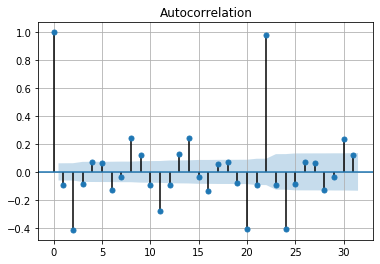

In [22]:
_ = plot_acf(test)
plt.grid()

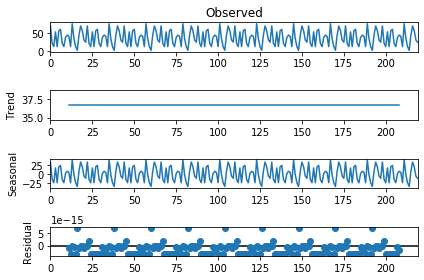

In [23]:
stl_data = seasonal_decompose(test[:220], period=22)
_=stl_data.plot()

Период $T = 22$

In [24]:
T = 22

In [25]:
full_periods = len(test)//22

In [26]:
test = test[:full_periods*22].reshape((full_periods, 22))
test

array([[69, 22, 13, ..., 56, 31, 25],
       [69, 22, 13, ..., 56, 31, 25],
       [69, 22, 13, ..., 56, 31, 25],
       ...,
       [69, 22, 13, ..., 56, 31, 25],
       [69, 22, 13, ..., 56, 31, 25],
       [69, 22, 13, ..., 56, 31, 25]])

Похоже, что данные не зашумлены

In [27]:
from collections import Counter

Counter(["".join(map(lambda c: chr(int(round(c/alpha)) + ord("a")), t)) for t in test])

Counter({'wheresthemoneylebowski': 43,
         'wheresthemonetlebowski': 1,
         'wheresthemonexlebowski': 1,
         'rheresthemoneylebowski': 1})

# Вывод:

Удалось расшифровать фразу "Where's the money Lebowski?", свидетельствующую об уважении авторов задачи к классике. В тестовой картинке искажения носили ненормальный характер - скачки в трех точках, это не помешало работе.